# HERA Cable Reflection Inspection.

The recipe for isolating cable reflections is

1) average autocorrelations over the 60 times in the observation to raise SNR.

2) delay-clean the time averaged autocorrelation (to remove flagging side-lobes for filtration step).

3) delay-filter the time-averaged autocorrelation (throw away all power less than 400 ns).

4) fit a sinusoid to the residual.

Right now the recipe is under-estimating the reflections on antenna 14 and antenna 2. 

In [32]:
%matplotlib inline
import numpy as np
import aipy
import matplotlib.pyplot as plt
import scipy.optimize as op
from pyuvdata import UVData
from numpy.fft import fft,fftshift,ifft,fftfreq
import scipy.signal as signal

In [33]:
def read_ant_pos():
    f=open('ants.txt')
    antnums=[]
    antnames=[]
    eastings=[]
    northings=[]
    altitudes=[]
    for line in f.readlines()[2:]:
        items=line.split('|')
        geo=items[-2]
        antname=items[1]
        antnum=int(antname[3:])
        geocoords=geo.split(',')
        east=float(geocoords[0][:-1])
        north=float(geocoords[1][:-1])
        alt=float(geocoords[2][:-2])
        antnums.append(antnum)
        antnames.append(antname)
        eastings.append(east)
        northings.append(north)
        altitudes.append(alt)
    return (antnames,antnums,np.array(eastings),
            np.array(northings),np.array(altitudes))
        

In [34]:
anames,anums,ante,antn,antalt=read_ant_pos()

First, we define a function that imports miriad autocorrelations using pyuvdata.

In [35]:
def get_autos(miriad_file,flag_file,flow=1e8,fhigh=2e8):
    '''
    get autocorrelations from a miriad file and a flag_file. 
    Returns times, antenna numbers, frequencies, and grid of autocorrsl. 
    '''
    uvt=UVData()
    uvt.read_miriad([miriad_file])
    uvt.flag_array=np.load(flag_file)['flag_array']
    utimes=np.unique(uvt.time_array)
    selection_f=np.logical_and(uvt.freq_array>=flow,uvt.freq_array<fhigh)
    nfreqs=len(selection_f[selection_f])
    output=np.zeros((uvt.Nants_data,uvt.Ntimes,nfreqs))
    output_flags=np.empty((uvt.Nants_data,uvt.Ntimes,nfreqs),dtype=bool)
    output_flags[:]=False
    channums=np.arange(uvt.Nfreqs).astype(int)[selection_f[0]]
    for tnum in range(uvt.Ntimes):
        for anum in range(uvt.Nants_data):
            antenna_number=uvt.antenna_numbers[anum]
            time=utimes[tnum]
            selection=np.logical_and(uvt.ant_1_array==antenna_number,
                                     np.logical_and(uvt.ant_2_array==antenna_number,
                                     uvt.time_array==time))
            selection_flag=np.logical_and(uvt.time_array==time,
                                         np.logical_or(uvt.ant_1_array==antenna_number,
                                         uvt.ant_2_array==antenna_number))          
            output[anum,tnum,:]=uvt.data_array[selection,0,selection_f[0],0].real
            output_flags[anum,tnum,:]=np.any(uvt.flag_array[selection_flag],axis=0).squeeze()[selection_f[0]]
    return uvt.antenna_numbers,utimes,uvt.freq_array[selection_f]/1e9,np.sqrt(output),output_flags

Now define some utility functions.

In [36]:
def poly_div(x,y,npoly):
    '''
    fit and divide out data by a polynomial.
    '''
    output=np.zeros_like(y);output[:]=y[:]
    pfit=np.polyfit(x,y,npoly)
    model=np.zeros(len(y))
    for m in range(npoly+1):
        model+=(pfit[m]*x**(npoly-m))
    return output/model
def dtrans(y):
    '''
    perform a blackman-harris windowed delay transorm.
    '''
    print len(y)
    window=signal.blackmanharris(len(y))
    window/=window.mean()
    return fftshift(ifft(fftshift(y*window)))
def dfilter(x,y,tmax):
    '''
    filter all power in y at delays lower than tmax. 
    x is a frequency vector. 
    '''
    tax=fftfreq(len(x),x[1]-x[0])
    window=signal.blackmanharris(len(x))
    window/=window.mean()
    dy=fft(y*window)
    dy[np.abs(tax)<tmax]=0
    return ifft(dy)/window
def ripple(x,y,*p):
    '''
    fitting function for a cable ripple
    '''
    return (p[0]*np.cos(2.*np.pi*x*p[1]+p[2]))
def fitripple(x,y,weights,flags,flow=.125,fhigh=.175):
    '''
    fit data vector y to a ripple as a function of frequency x
    weights=sqrt(1/sigma^2)
    flags: not to include in fit
    flow: lowest frequency you want to use for fit. 
    fhigh: highest frequency you want to use for fit. 
    '''
    output=np.zeros(len(y))    
    pnot=np.std(y)
    nx=len(x)
    xfit=x-x[nx/2]
    dx0=4e5/1e9
    #select_fit0=np.logical_and[x>=]
    #initialize p0 using linear fit to 400kHz around 0
    deltax=fhigh-flow
    selection=np.logical_and(np.logical_and(x>=flow,x<fhigh),np.invert(flags))
    p0=[np.std(y[selection])*2,0,1250.,0]
    popt,_=op.curve_fit(ripple,x[selection],y[selection],p0=p0,sigma=1/weights[selection]) 
    deltax=fhigh-flow
    selection=np.logical_and(np.logical_and(x>=flow-deltax,x<fhigh+deltax),np.invert(flags))
    #double frequency range.
    popt,_=op.curve_fit(ripple,x[selection],y[selection],p0=p0,sigma=1/weights[selection])
    return popt

In [37]:
def delay_clean_gentle(data,window,kernel,area,noiseArea,nsigma=10.,gain=.1,miniter=1):
    '''
    delay clean data with fft window window and cleaning kernel kernel within the area vector area
    noiseArea specifies which regions of delay space are used to compute noise level. 
    will continue iteratively cleaning until the signal within area has a stdev within nsigma of 
    the std of power in noiseArea. 
    '''
   #double area for noise area
    
    dDelay=ifft(data*window)
    dKernel=ifft(kernel)
    #area=fftshift(area).astype(int)
    #noiseArea=fftshift(noiseArea).astype(int)
    noiseSTD=np.sqrt(np.mean(np.abs(dDelay[noiseArea==1])**2.))
    signalSTD=np.sqrt(np.mean(np.abs(dDelay[area==1]))**2.)
    good=signalSTD>=nsigma*noiseSTD
    iters=0
    #print('nsigma=%.2f'%(signalSTD/noiseSTD))
    #print good
    while(good or iters<miniter):
        iters+=1
        cc,info=aipy.deconv.clean(dDelay,dKernel,area=area,tol=1e-3,gain=gain,maxiter=int(1e3),stop_if_div=False,verbose=False)
        signalSTD=np.sqrt(np.mean(np.abs(info['res'][area==1])**2.))
        noiseSTD=np.sqrt(np.mean(np.abs(info['res'][noiseArea==1])**2.))
        good=signalSTD>=nsigma*noiseSTD
        #print('nsigma=%.2f'%(signalSTD/noiseSTD))

        if(good):
            dDelay=info['res']
    return fft(dDelay)/window

Below, I test cleaning on a simple data vector consisting of noise, zero-delay power, a nuesance mode at 1 ns and a signal at 5 ns that I want to recover. 

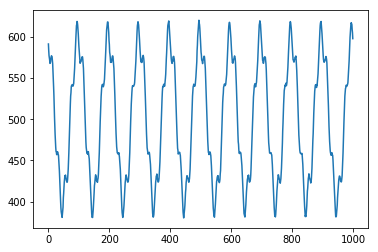

/Users/ewallwic/miniconda2/envs/hera/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-50, 50)

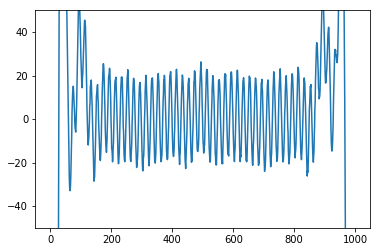

In [38]:
nf=1000
df=0.01
faxis=np.arange(-nf/2,nf/2)*df
taxis=fftfreq(faxis.shape[0],faxis[1]-faxis[0])
test=np.ones(nf)*500.+np.random.randn(nf)+100*np.cos(2*np.pi*1*faxis+.2)+20*np.cos(2*np.pi*5*faxis+2.)
areatest=np.zeros(len(taxis))
areatest[np.abs(taxis)<2]=1
areanoise=np.zeros(len(taxis))
areanoise[np.abs(taxis)>10]=1
plt.plot(test)
plt.show()
cleantest=delay_clean_gentle(test,signal.blackmanharris(nf),np.ones(nf),areatest,areanoise)
plt.plot(cleantest)
plt.ylim(-50,50)

Next I test the delay-cleaning with some flags. Things seem to still work.

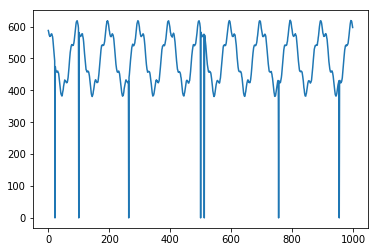

(-50, 50)

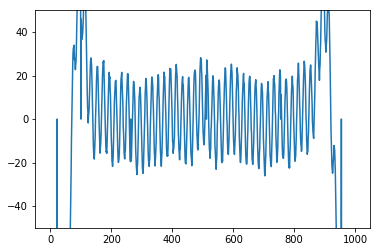

In [39]:
nf=1000
df=0.01
faxis=np.arange(-nf/2,nf/2)*df
taxis=fftfreq(faxis.shape[0],faxis[1]-faxis[0])
test=np.ones(nf)*500.+np.random.randn(nf)+100*np.cos(2*np.pi*1*faxis+.2)+20*np.cos(2*np.pi*5*faxis+2.)
test[[100,22,-45,264,512,500,756]]=0
kernel=np.ones(len(test))
kernel[test==0]=0
areatest=np.zeros(len(taxis))
areatest[np.abs(taxis)<2]=1
areanoise=np.zeros(len(taxis))
areanoise[np.abs(taxis)>10]=1
plt.plot(test)
plt.show()
cleantest=delay_clean_gentle(test,signal.blackmanharris(nf),kernel,areatest,areanoise)
plt.plot(cleantest)
plt.ylim(-50,50)

Now load up an auto-correlation.

divide by zero encountered in divide
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


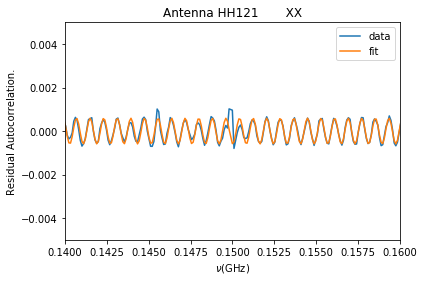

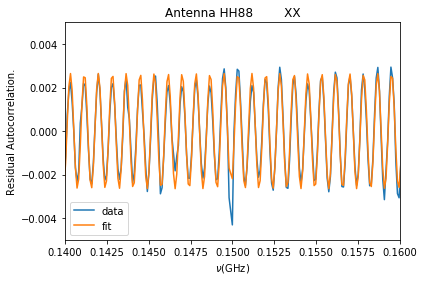

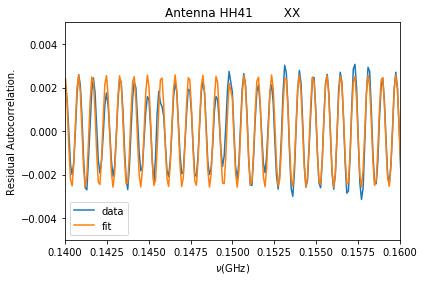

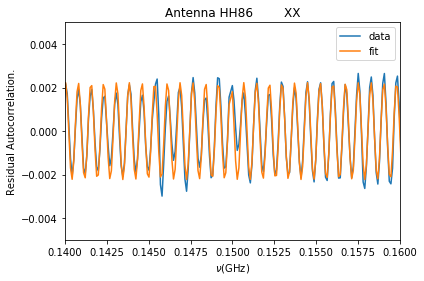

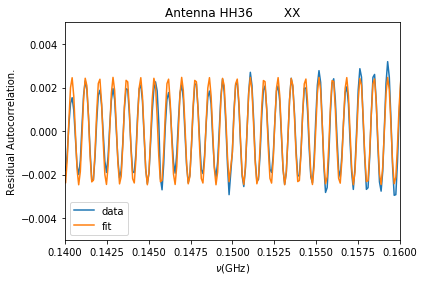

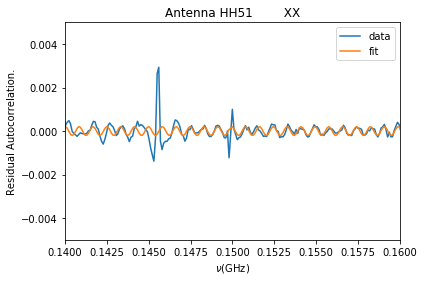

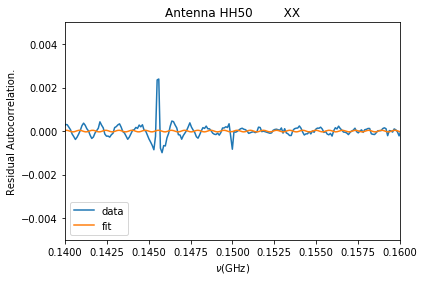

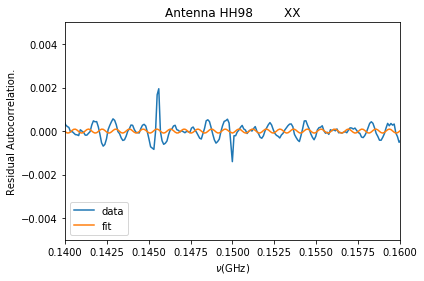

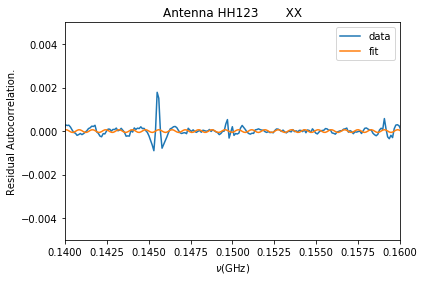

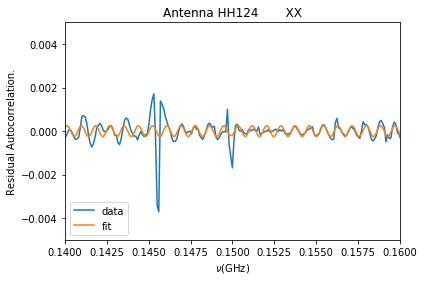

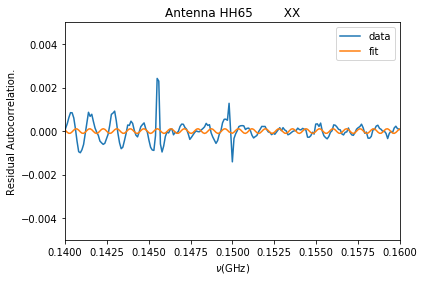

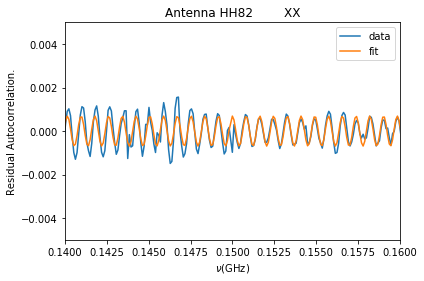

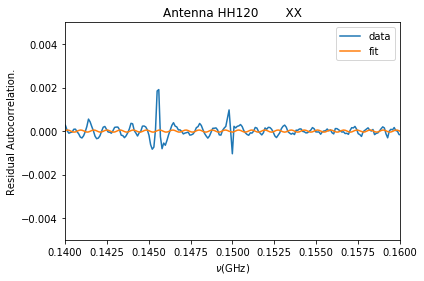

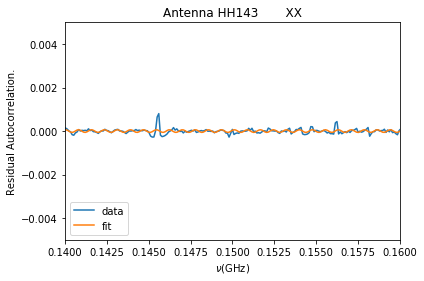

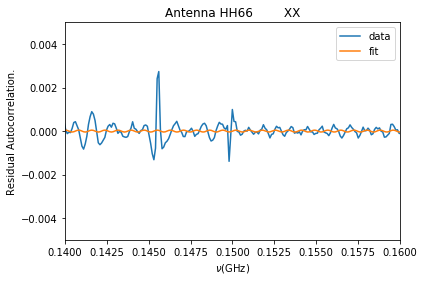

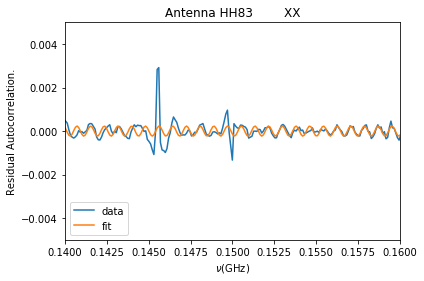

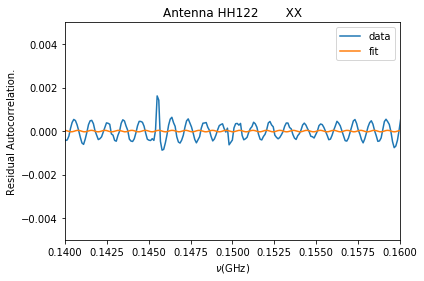

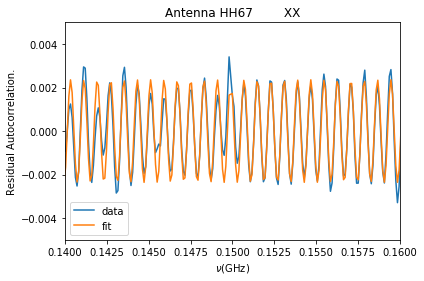

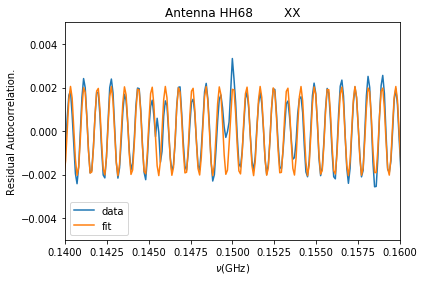

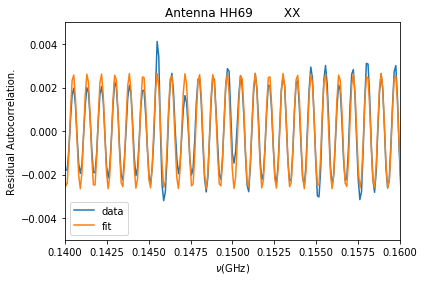

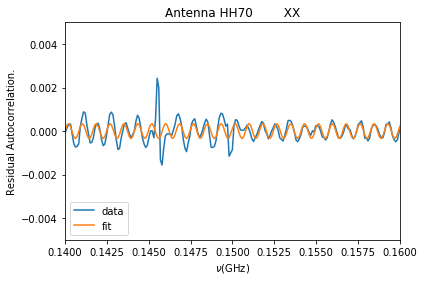

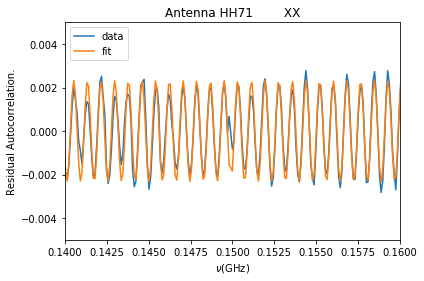

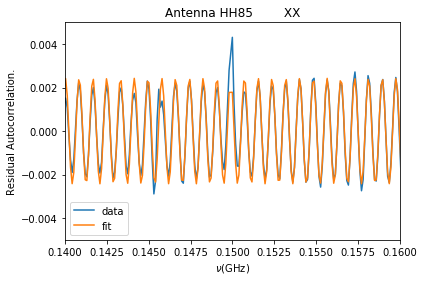

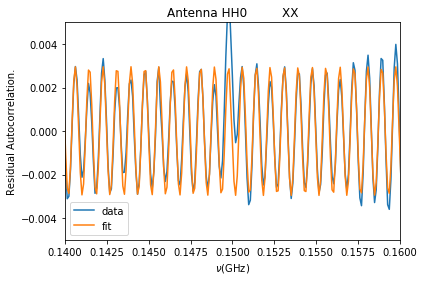

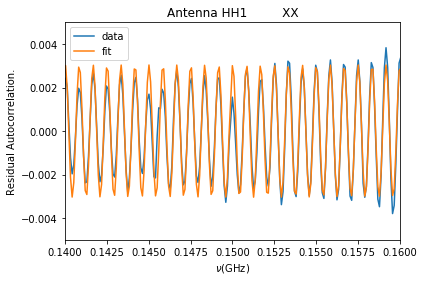

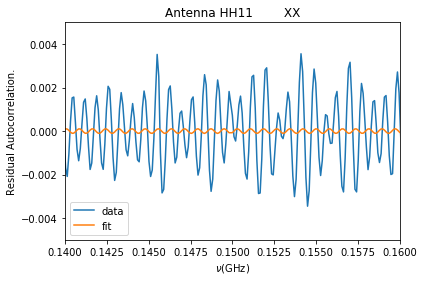

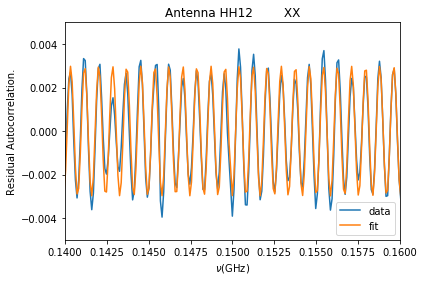

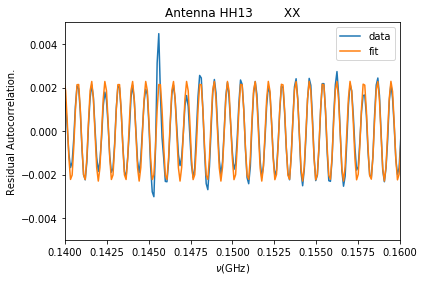

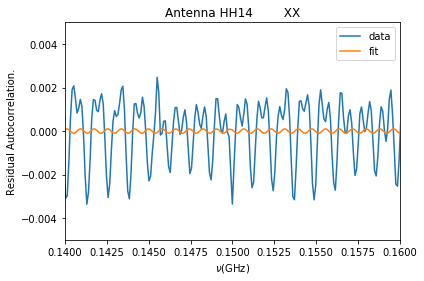

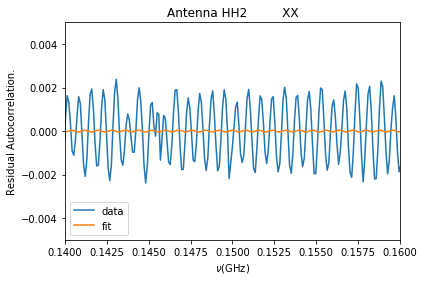

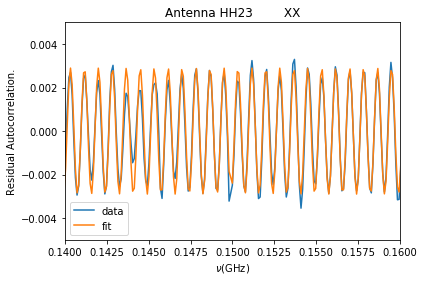

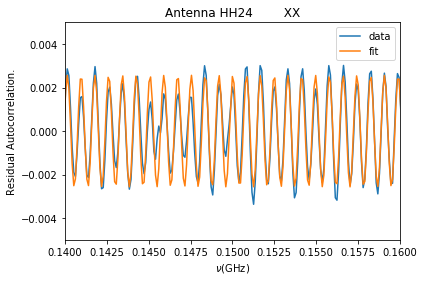

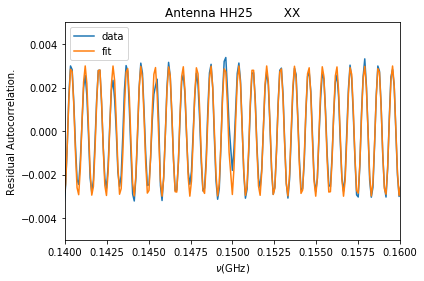

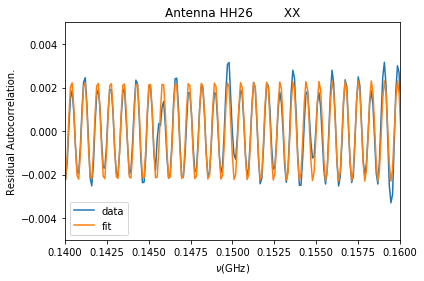

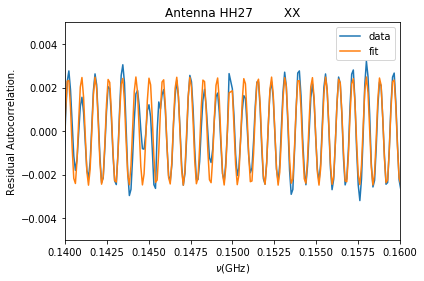

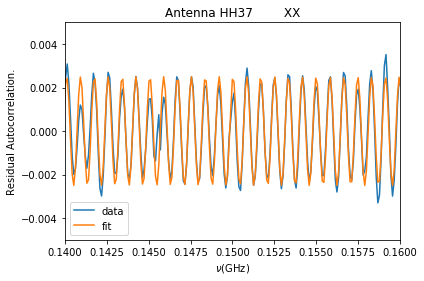

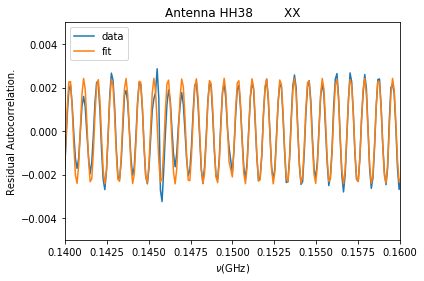

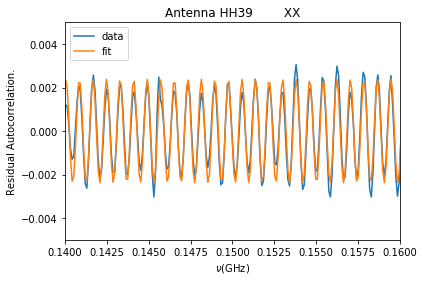

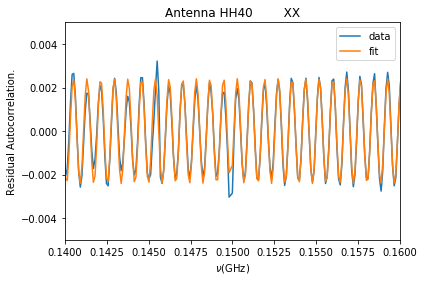

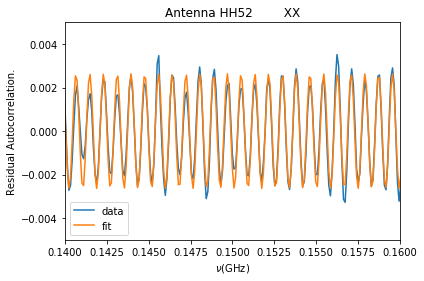

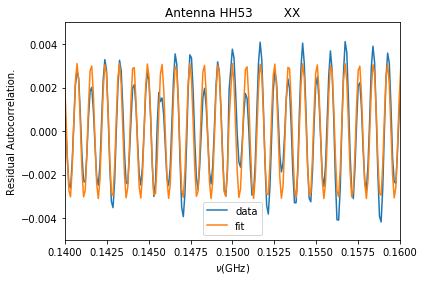

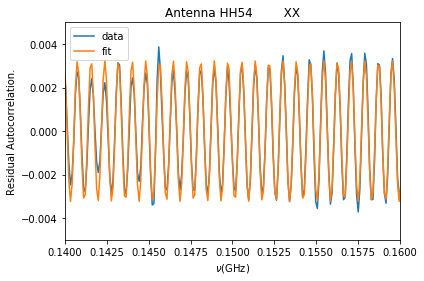

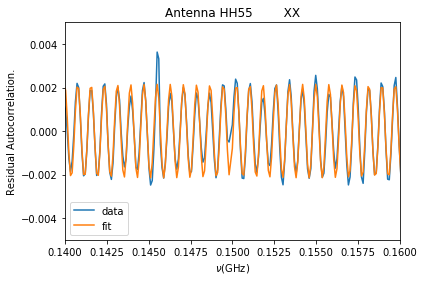

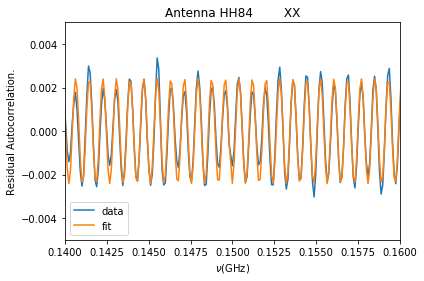

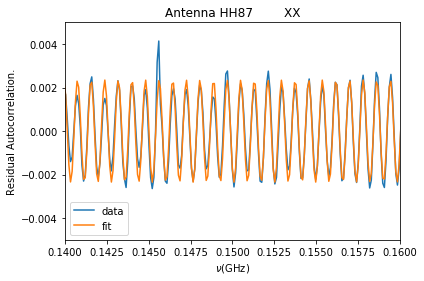

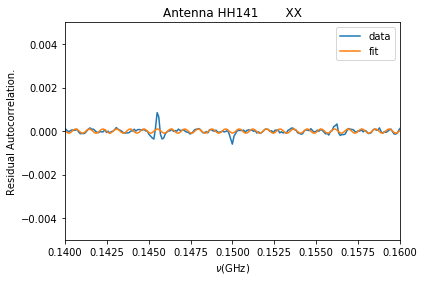

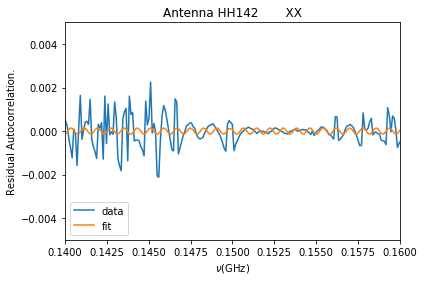

In [82]:
antnums,times,freqs,autos,flags=get_autos('zen.2458035.26411.xx.HH.uv','zen.2458035.26411.xx.HH.uvO.flags.npz',130e6,180e6)

flags_tavg=np.empty(autos_tavg.shape,dtype=bool)#flags for time averaged data
autos_pd_tavg=np.zeros_like(autos_tavg)#time averaged data with polynomial divided out
autos_tavg=np.zeros((autos.shape[0],autos.shape[-1]))#time averaged data
cleaned_tavg=np.zeros_like(autos_tavg)#time averaged data that has been delay cleaned
taxis=fftfreq(len(freqs),freqs[1]-freqs[0])#time axis
aclean=np.zeros(len(taxis),dtype=int)
anoise=np.zeros(len(taxis),dtype=int)
aclean[np.abs(taxis)<400]=1
anoise[np.abs(taxis)>taxis.max()*3/4.]=1
for anum in range(autos.shape[0]):
    for chan in range(autos.shape[-1]):
        autos_tavg[anum,chan]=np.mean(autos[anum,np.invert(flags[anum,:,chan]),chan])
        flags_tavg[anum,chan]=np.all(flags[anum,:,chan])
    selection=np.invert(flags_tavg[anum,:])
    kernel=np.ones(autos_tavg.shape[-1])
    kernel[np.invert(selection)]=0
    window=signal.blackmanharris(len(kernel))
    window/=window.mean()
    autos_pd_tavg[anum,selection]=poly_div(freqs[selection],autos_tavg[anum,selection],3)
    autos_pd_tavg[anum,np.invert(selection)]=0
    cleaned_tavg[anum,:]=delay_clean_gentle(autos_pd_tavg[anum,:]-np.mean(autos_pd_tavg[anum,selection]),
                                            kernel,
                                            window,
                                            aclean,
                                            anoise,
                                            nsigma=16.,
                                            gain=.1
                                           )
cleaned_tavg[np.isinf(cleaned_tavg)]=0
dfiltered_tavg=np.zeros_like(cleaned_tavg)
popts=np.zeros((dfiltered_tavg.shape[0],4))
for m in range(dfiltered_tavg.shape[0]):
    dfiltered_tavg[m,:]=dfilter(freqs,cleaned_tavg[m,:],700)
    popts[m,:]=fitripple(freqs,dfiltered_tavg[m,:],
                         weights=signal.blackmanharris(len(freqs)),
                         flags=flags_tavg[m,:],
                         flow=.145,
                         fhigh=.155
                         )
for m in range(len(antnums)):
    selection=np.invert(flags_tavg[m,:])
    plt.plot(freqs[selection],dfiltered_tavg[m,selection],label='data')
    plt.plot(freqs[selection],ripple(freqs[selection],*popts[m,:]),label='fit')
    antname=anames[anums.index(antnums[m])]
    plt.title('Antenna'+antname+' XX')
    plt.xlim(0.14,0.16)
    plt.ylim(-5e-3,5e-3)
    plt.xlabel('$\\nu$(GHz)')
    plt.ylabel('Residual Autocorrelation.')
    plt.legend()
    plt.show()
plt.hist(np.log10(np.abs(popts[:,1])))
plt.xlabel('log10(reflection amp)')
plt.ylabel('counts')
plt.show()
plt.hist((np.abs(popts[:,2])))
plt.xlabel('delay (ns)')
plt.ylabel('counts')



Now scatter plot the amplitudes versus the array location.

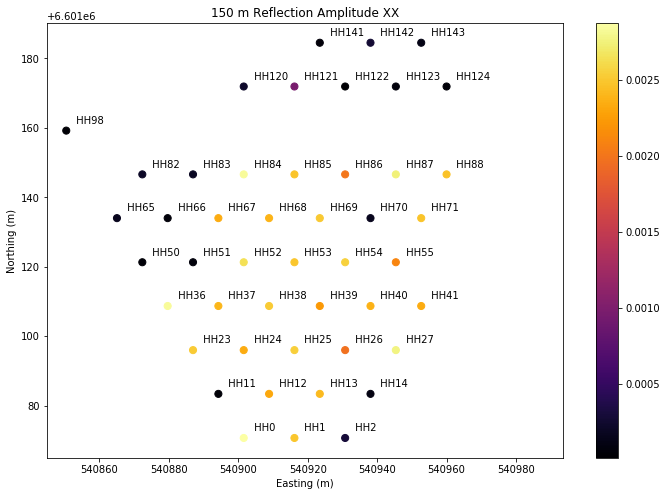

In [92]:
#organize reflection amplitudes by ordering of name amplitudes.
organized_e=np.zeros(len(antnums))
organized_n=np.zeros(len(antnums))
organized_names=['' for m in range(len(antnums))]
for antind in range(len(antnums)):
    geoind=anums.index(antnums[antind])
    organized_e[antind]=ante[geoind]
    organized_n[antind]=antn[geoind]
    organized_names[antind]=anames[geoind]
plt.scatter(organized_e,organized_n,c=np.abs(popts[:,1]),cmap='inferno',s=50)
for m in range(len(organized_e)):
    plt.text(organized_e[m]+2,organized_n[m]+2,organized_names[m])
plt.colorbar()
plt.title('150 m Reflection Amplitude XX')
plt.gcf().set_size_inches(12,8)
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
xlims=plt.gca().get_xlim()
plt.xlim([xlims[0],xlims[1]+28])
plt.gca().set_aspect('equal')

Here's a little plot to demonstrate the efficacy of the cleaning versus cleaning and filtering.

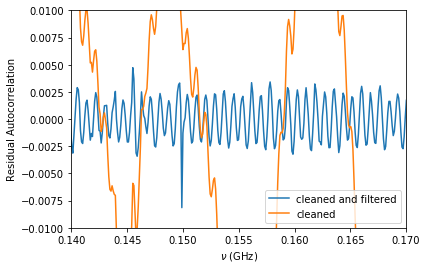

In [91]:
for m in range(21,22):
    selection=np.invert(flags_tavg[m])
    plt.plot(freqs,dfilter(freqs,cleaned_tavg[m,:],600),label='cleaned and filtered')
    plt.plot(freqs[selection],cleaned_tavg[m,selection],label='cleaned')
plt.legend()
plt.ylim(-.01,.01)
plt.xlim(.14,.17)
plt.xlabel('$\\nu$ (GHz)')
plt.ylabel('Residual Autocorrelation')

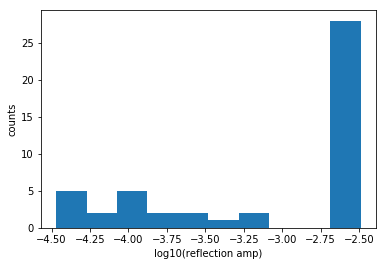

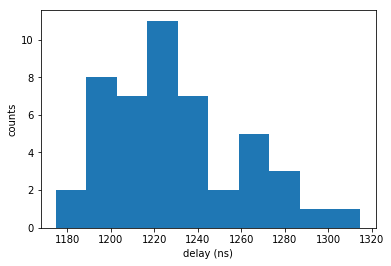

In [47]:
plt.hist(np.log10(np.abs(popts[:,1])))
plt.xlabel('log10(reflection amp)')
plt.ylabel('counts')
plt.show()
plt.hist((np.abs(popts[:,2])))
plt.xlabel('delay (ns)')
plt.ylabel('counts')

divide by zero encountered in divide
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


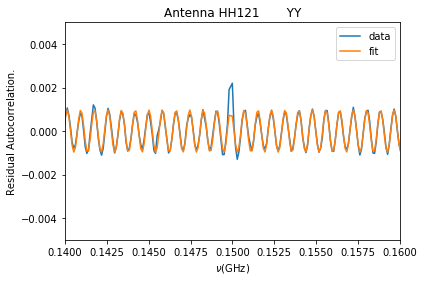

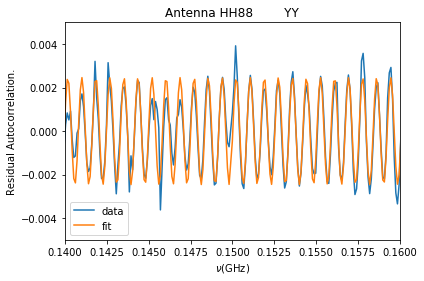

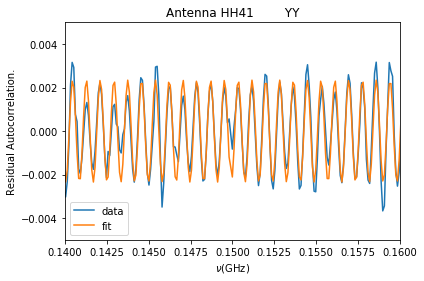

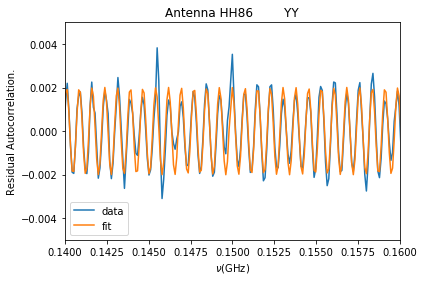

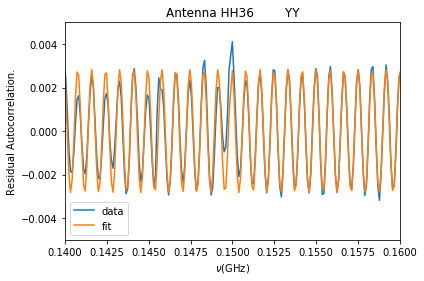

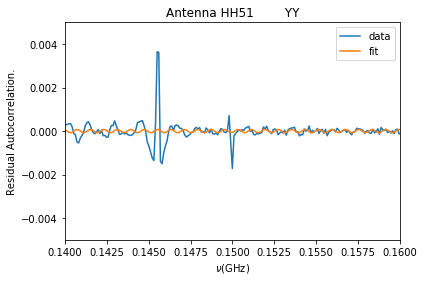

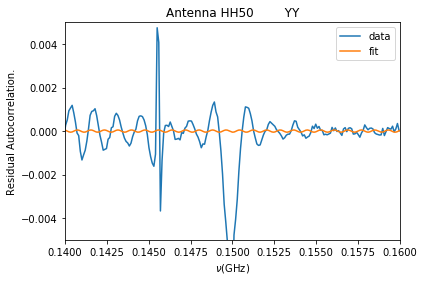

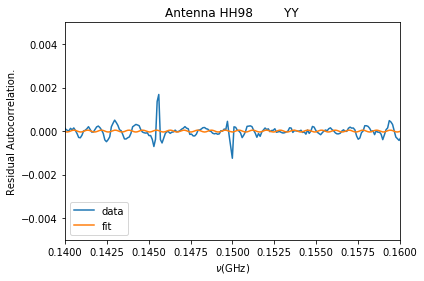

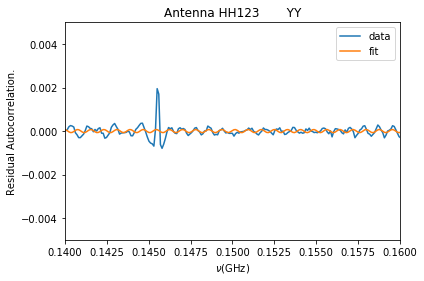

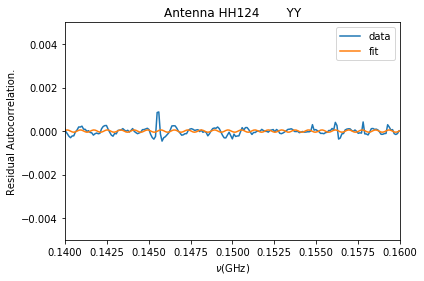

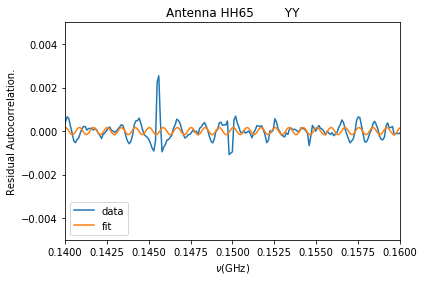

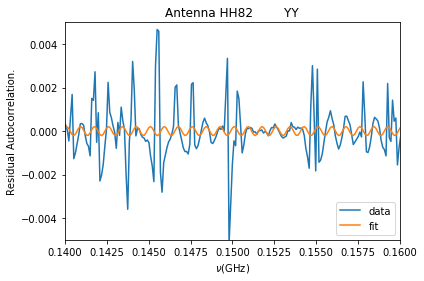

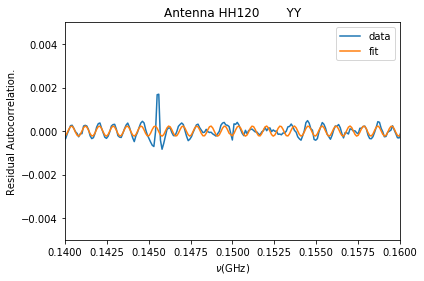

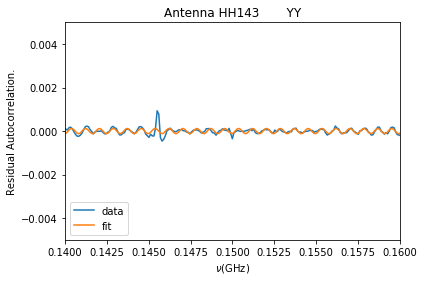

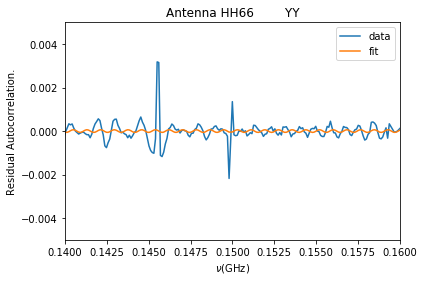

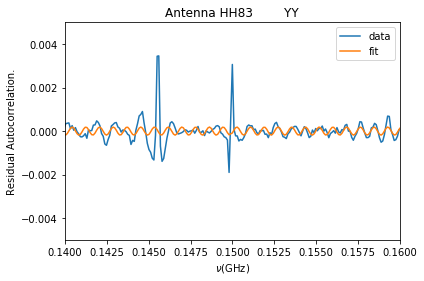

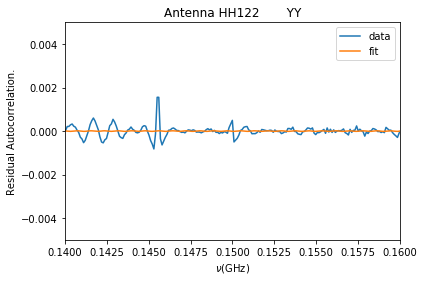

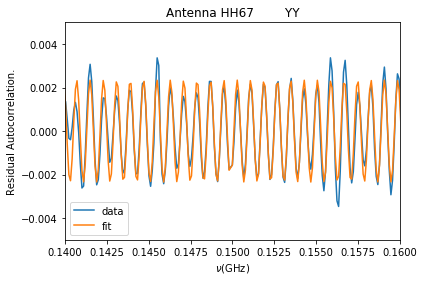

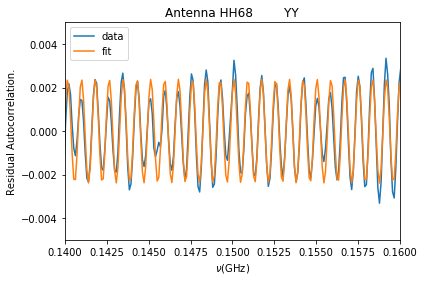

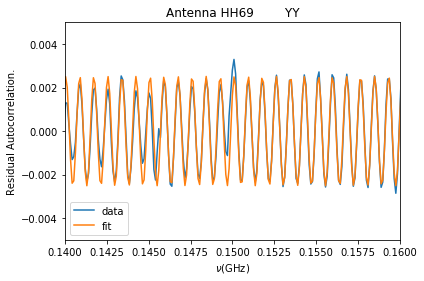

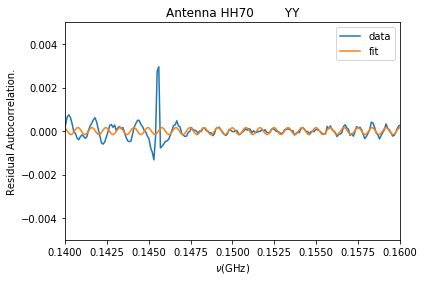

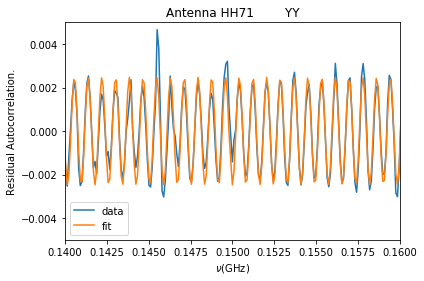

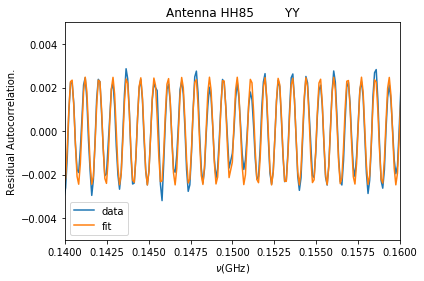

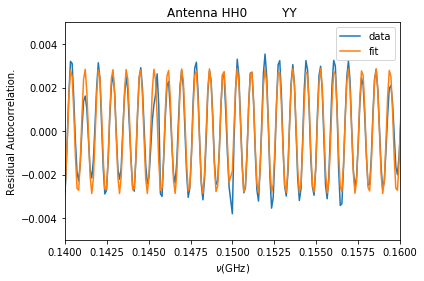

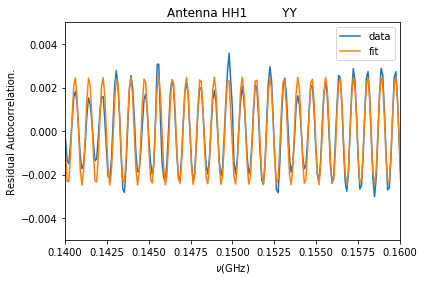

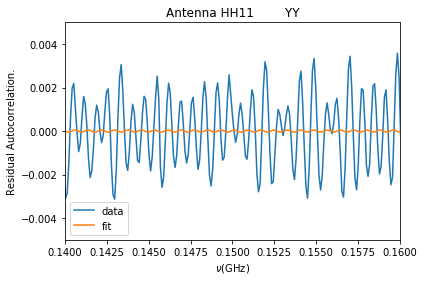

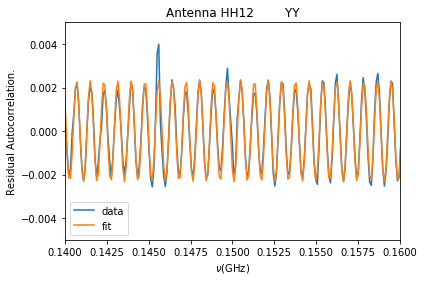

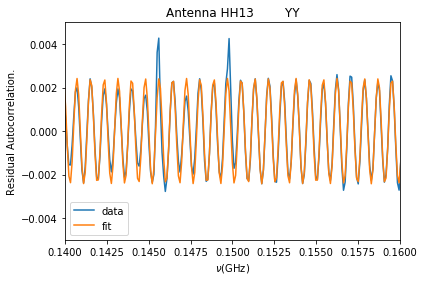

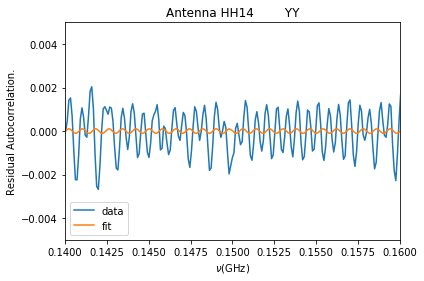

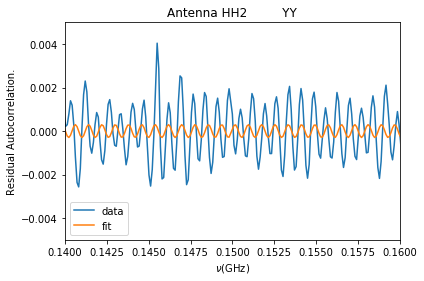

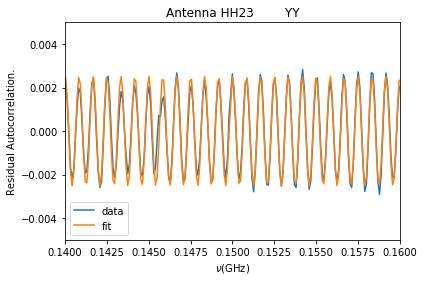

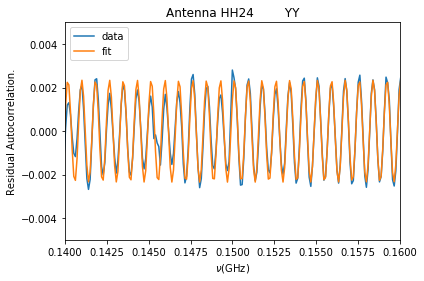

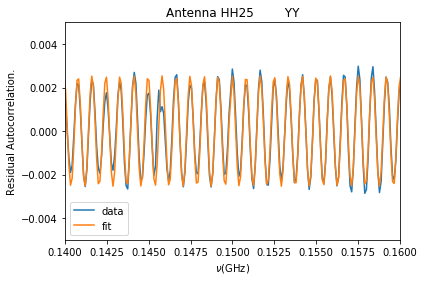

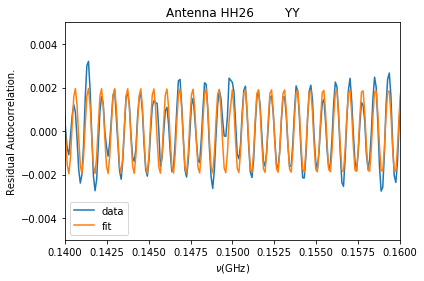

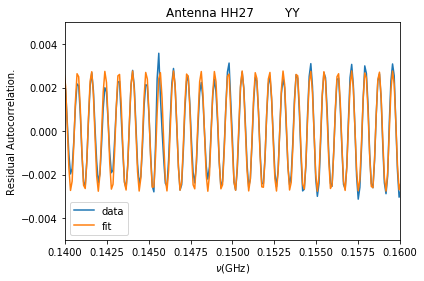

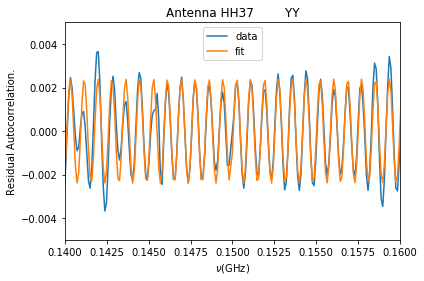

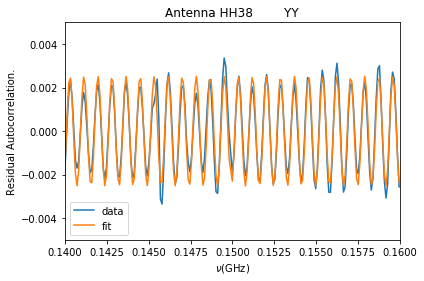

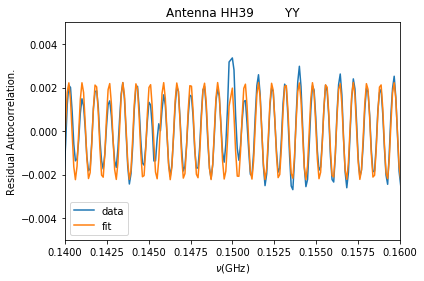

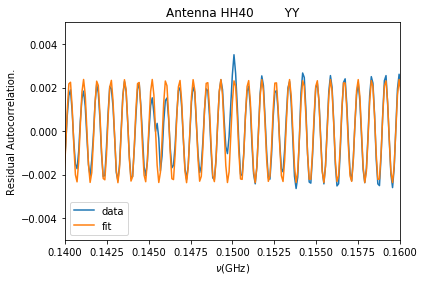

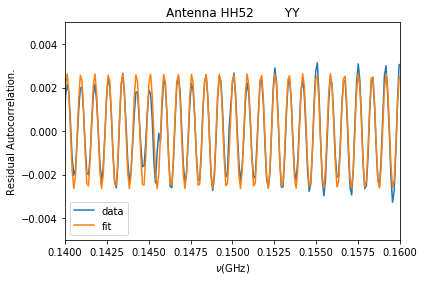

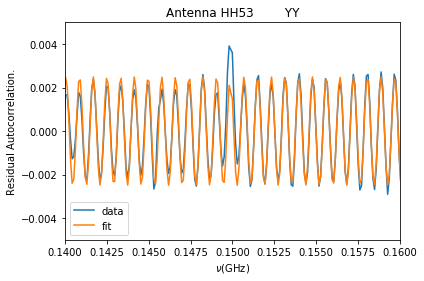

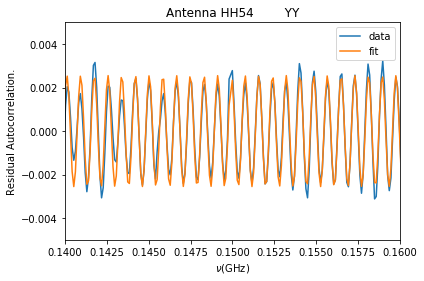

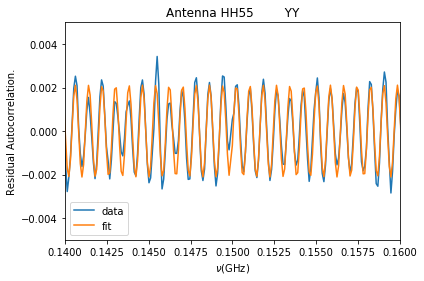

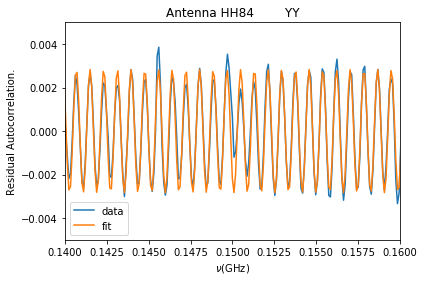

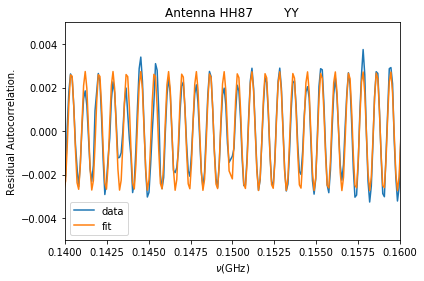

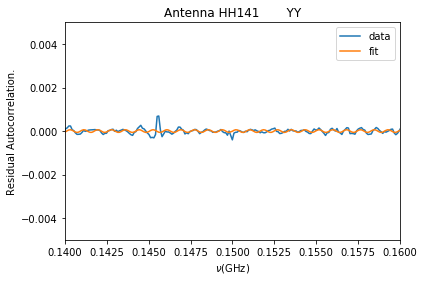

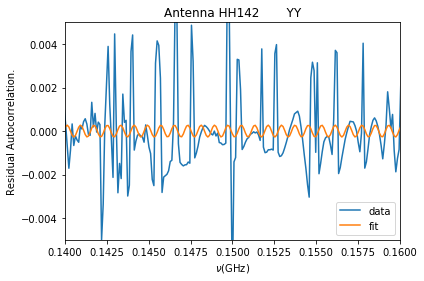

In [86]:
antnums,times,freqs,autos,flags=get_autos('zen.2458035.26411.yy.HH.uv','zen.2458035.26411.yy.HH.uvO.flags.npz',130e6,180e6)

flags_tavg=np.empty(autos_tavg.shape,dtype=bool)#flags for time averaged data
autos_pd_tavg=np.zeros_like(autos_tavg)#time averaged data with polynomial divided out
autos_tavg=np.zeros((autos.shape[0],autos.shape[-1]))#time averaged data
cleaned_tavg=np.zeros_like(autos_tavg)#time averaged data that has been delay cleaned
taxis=fftfreq(len(freqs),freqs[1]-freqs[0])#time axis
aclean=np.zeros(len(taxis),dtype=int)
anoise=np.zeros(len(taxis),dtype=int)
aclean[np.abs(taxis)<400]=1
anoise[np.abs(taxis)>taxis.max()*3/4.]=1
for anum in range(autos.shape[0]):
    for chan in range(autos.shape[-1]):
        autos_tavg[anum,chan]=np.mean(autos[anum,np.invert(flags[anum,:,chan]),chan])
        flags_tavg[anum,chan]=np.all(flags[anum,:,chan])
    selection=np.invert(flags_tavg[anum,:])
    kernel=np.ones(autos_tavg.shape[-1])
    kernel[np.invert(selection)]=0
    window=signal.blackmanharris(len(kernel))
    window/=window.mean()
    autos_pd_tavg[anum,selection]=poly_div(freqs[selection],autos_tavg[anum,selection],3)
    autos_pd_tavg[anum,np.invert(selection)]=0
    cleaned_tavg[anum,:]=delay_clean_gentle(autos_pd_tavg[anum,:]-np.mean(autos_pd_tavg[anum,selection]),
                                            kernel,
                                            window,
                                            aclean,
                                            anoise,
                                            nsigma=16.,
                                            gain=.1
                                           )
cleaned_tavg[np.isinf(cleaned_tavg)]=0
dfiltered_tavg=np.zeros_like(cleaned_tavg)
popts=np.zeros((dfiltered_tavg.shape[0],4))
for m in range(dfiltered_tavg.shape[0]):
    dfiltered_tavg[m,:]=dfilter(freqs,cleaned_tavg[m,:],700)
    popts[m,:]=fitripple(freqs,dfiltered_tavg[m,:],
                         weights=signal.blackmanharris(len(freqs)),
                         flags=flags_tavg[m,:],
                         flow=.145,
                         fhigh=.155
                         )
for m in range(len(antnums)):
    selection=np.invert(flags_tavg[m,:])
    plt.plot(freqs[selection],dfiltered_tavg[m,selection],label='data')
    plt.plot(freqs[selection],ripple(freqs[selection],*popts[m,:]),label='fit')
    antname=anames[anums.index(antnums[m])]
    plt.title('Antenna'+antname+' YY')
    plt.xlim(0.14,0.16)
    plt.ylim(-5e-3,5e-3)
    plt.xlabel('$\\nu$(GHz)')
    plt.ylabel('Residual Autocorrelation.')
    plt.legend()
    plt.show()
    

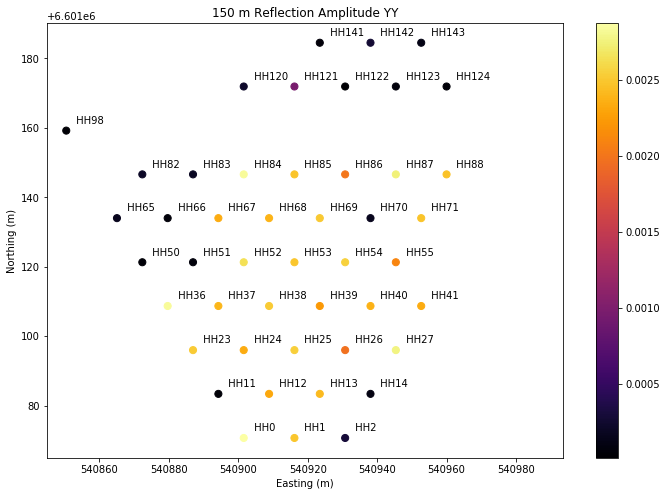

In [85]:

#organize reflection amplitudes by ordering of name amplitudes.
organized_e=np.zeros(len(antnums))
organized_n=np.zeros(len(antnums))
organized_names=['' for m in range(len(antnums))]
for antind in range(len(antnums)):
    geoind=anums.index(antnums[antind])
    organized_e[antind]=ante[geoind]
    organized_n[antind]=antn[geoind]
    organized_names[antind]=anames[geoind]
plt.scatter(organized_e,organized_n,c=np.abs(popts[:,1]),cmap='inferno',s=50)
for m in range(len(organized_e)):
    plt.text(organized_e[m]+2,organized_n[m]+2,organized_names[m])
plt.colorbar()
plt.title('150 m Reflection Amplitude YY')
plt.gcf().set_size_inches(12,8)
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
xlims=plt.gca().get_xlim()
plt.xlim([xlims[0],xlims[1]+28])
plt.gca().set_aspect('equal')